Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/auctions_query
Response: <Response [200]>

Set of all unique security types found in the data:
{'CMB', 'Bond', 'TIPS Note', 'Bill', 'TIPS Bond', 'Note', 'FRN Note'}
(6022, 6)
(6019, 6)

Preview of yearly issuance data:
(20, 4)
category          Bill          Bond          Note         Other
year                                                            
2006      3.391226e+12  4.639796e+10  7.421478e+11  2.420021e+11
2007      3.486298e+12  5.448508e+10  6.977195e+11  2.560029e+11
2008      4.195442e+12  6.366661e+10  9.657788e+11  1.432009e+12
2009      5.275833e+12  1.513329e+11  2.045879e+12  1.142012e+12
2010      4.852568e+12  1.898829e+11  2.129860e+12  1.247029e+12


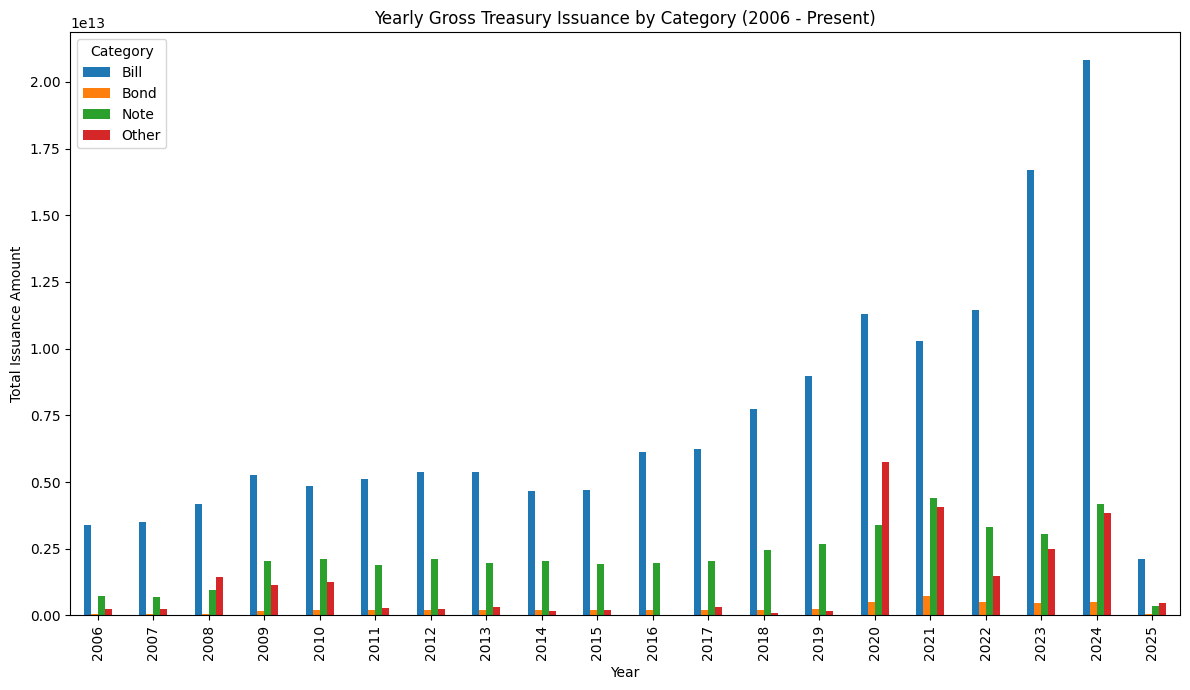

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Base URL for the Fiscal Data Treasury API.
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
# Using the auctions_query endpoint from the accounting/od dataset (v1).
endpoint = "/v1/accounting/od/auctions_query"

# Set query parameters:
params = {
    "fields": "record_date,security_type,security_term,total_accepted,maturity_date",
    "sort": "-record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

# Set up headers.
headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

# Construct the URL and make the API request.
url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
data = json_response["data"]

# Load the JSON data into a DataFrame.
df = pd.DataFrame(data)

# Convert date fields to datetime.
df["record_date"] = pd.to_datetime(df["record_date"])
df["maturity_date"] = pd.to_datetime(df["maturity_date"], errors="coerce")

# Convert the accepted amount to numeric.
df["total_accepted"] = pd.to_numeric(df["total_accepted"], errors="coerce")

# ** Collect all unique security types in the dataset **
unique_security_types = set(df["security_type"].dropna())

print("\nSet of all unique security types found in the data:")
print(unique_security_types)

# Function to classify each security into one of three groups.
def categorize_security(security_type):
    if "Bill" in security_type:
        return "Bill"
    elif "Note" in security_type or "Coupon" in security_type:
        return "Note"
    elif "Bond" in security_type:
        return "Bond"
    else:
        return "Other"

# Create a new column for the security category.
df["category"] = df["security_type"].apply(categorize_security)

# Optionally, drop rows without a valid total_accepted amount.
print(df.shape)  # Output: (number_of_rows, number_of_columns)

df = df.dropna(subset=["total_accepted"])
print(df.shape)  # Output: (number_of_rows, number_of_columns)


# --- Aggregation by Year ---
df["year"] = df["record_date"].dt.year
yearly_issuance = df.groupby(["year", "category"])["total_accepted"].sum().reset_index()

# Pivot the table so that each year is a row and columns represent each category.
pivot_df = yearly_issuance.pivot(index="year", columns="category", values="total_accepted")
pivot_df = pivot_df.fillna(0)  # Replace missing values with 0

print("\nPreview of yearly issuance data:")
print(pivot_df.shape)  # Output: (number_of_rows, number_of_columns)
print(pivot_df.head())

# --- Plotting ---
pivot_df.plot(kind="bar", figsize=(12, 7))
plt.xlabel("Year")
plt.ylabel("Total Issuance Amount")
plt.title("Yearly Gross Treasury Issuance by Category (2006 - Present)")
plt.legend(title="Category")
plt.tight_layout()
plt.show()

Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/auctions_query
Response: <Response [200]>

Unique security types found:
{'Note', 'TIPS Bond', 'TIPS Note', 'CMB', 'Bill', 'Bond', 'FRN Note'}


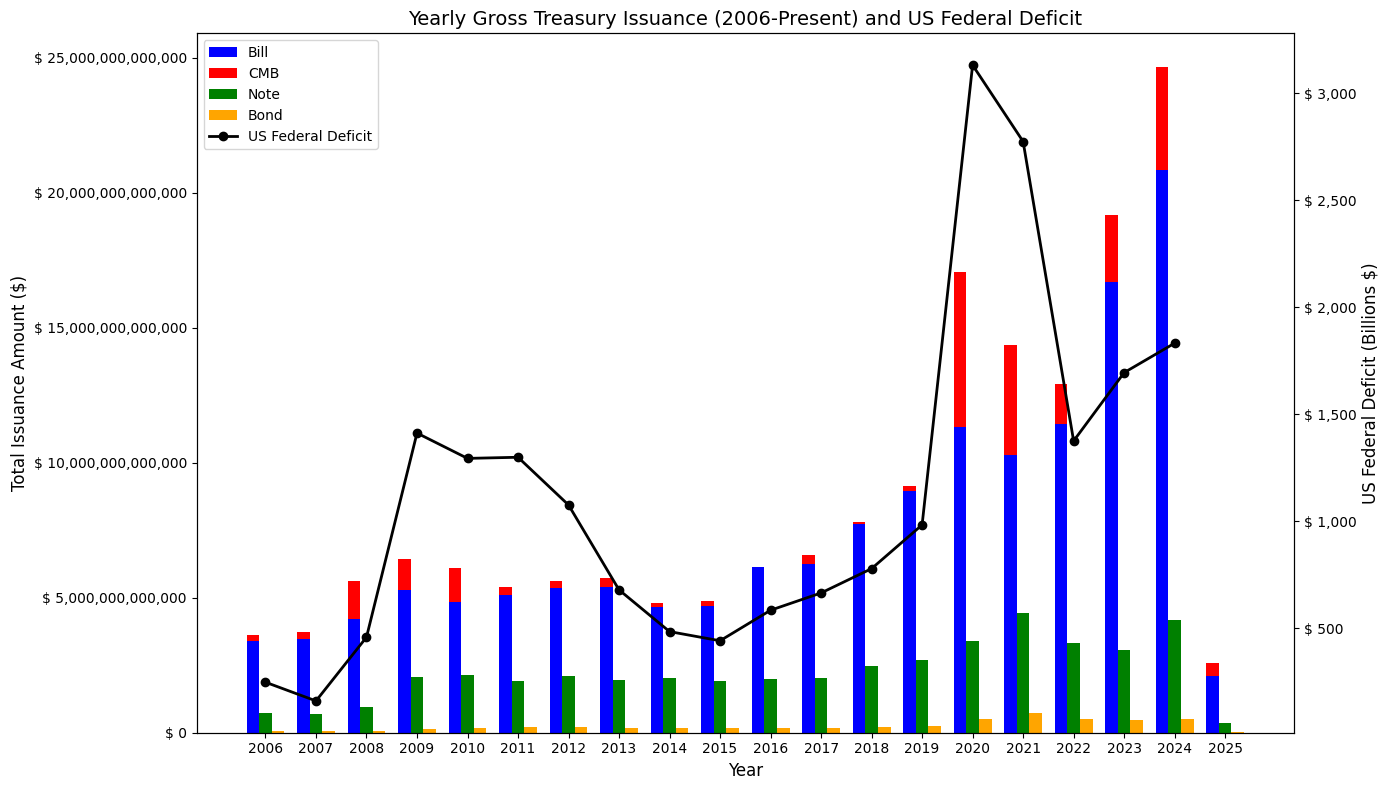

In [9]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime
from matplotlib.ticker import StrMethodFormatter

# -----------------------------
# Part 1: Retrieve Treasury Auction Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/accounting/od/auctions_query"

params = {
    "fields": "record_date,security_type,security_term,total_accepted,maturity_date",
    "sort": "-record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

df["record_date"] = pd.to_datetime(df["record_date"])
df["maturity_date"] = pd.to_datetime(df["maturity_date"], errors='coerce')
df["total_accepted"] = pd.to_numeric(df["total_accepted"], errors="coerce")

unique_security_types = set(df["security_type"].dropna())
print("\nUnique security types found:")
print(unique_security_types)

# -----------------------------
# Part 2: Categorize Securities
# -----------------------------
def categorize_security(security_type):
    if "CMB" in security_type or "Cash Management" in security_type:
        return "CMB"
    elif "Bill" in security_type:
        return "Bill"
    elif "Note" in security_type or "Coupon" in security_type:
        return "Coupon"
    elif "Bond" in security_type:
        return "Bond"
    else:
        return "Other"

df["category"] = df["security_type"].apply(categorize_security)
df = df.dropna(subset=["total_accepted"])

# -----------------------------
# Part 3: Aggregate Issuance by Year
# -----------------------------
df["year"] = df["record_date"].dt.year
yearly_issuance = df.groupby(["year", "category"])["total_accepted"].sum().reset_index()
pivot_df = yearly_issuance.pivot(index="year", columns="category", values="total_accepted")
pivot_df = pivot_df.fillna(0)

years = sorted(pivot_df.index)
bill_vals = pivot_df.get("Bill", pd.Series(0, index=years))
cmb_vals = pivot_df.get("CMB", pd.Series(0, index=years))
coupon_vals = pivot_df.get("Coupon", pd.Series(0, index=years))
bond_vals = pivot_df.get("Bond", pd.Series(0, index=years))

# -----------------------------
# Part 4: Retrieve US Federal Deficit Data from FRED
# -----------------------------
# Retrieve the deficit series (FYFSD) via FRED.
fred = Fred(api_key="b1b93f854d911b3cdc94df6dd9ec0365")
deficit_series = fred.get_series("FYFSD", observation_start="2006-01-01")
deficit_annual = deficit_series.resample("YE").mean()

# Invert the deficit (multiply by -1) so that a deficit (negative) becomes positive.
# Then, divide by 1,000 to convert the raw values (likely in millions) to billions.
deficit_annual = (-deficit_annual) / 1000

# Convert the index to the year.
deficit_annual.index = deficit_annual.index.year
deficit_annual = deficit_annual.reindex(years, fill_value=np.nan)

# -----------------------------
# Part 5: Plot Grouped Bars and Federal Deficit Line
# -----------------------------
x = np.arange(len(years))
width = 0.25

fig, ax1 = plt.subplots(figsize=(14, 8))

# Stacked bar: Bills (blue) and CMBs (red) grouped together.
ax1.bar(x - width, bill_vals, width, color='blue', label='Bill')
ax1.bar(x - width, cmb_vals, width, bottom=bill_vals, color='red', label='CMB')
ax1.bar(x, coupon_vals, width, color='green', label='Note')
ax1.bar(x + width, bond_vals, width, color='orange', label='Bond')

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Total Issuance Amount ($)", fontsize=12)
ax1.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))
ax1.set_title("Yearly Gross Treasury Issuance (2006-Present) and US Federal Deficit", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

# Secondary y-axis for US federal deficit.
ax2 = ax1.twinx()
ax2.plot(x, deficit_annual.values, color='black', marker='o', linewidth=2, label="US Federal Deficit")
ax2.set_ylabel("US Federal Deficit (Billions $)", fontsize=12)
ax2.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))

bars, labels = ax1.get_legend_handles_labels()
line, line_label = ax2.get_legend_handles_labels()
ax1.legend(bars + line, labels + line_label, loc='upper left')

plt.tight_layout()
plt.show()


Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/accounting/od/auctions_query
Response: <Response [200]>

Unique security types found:
{'TIPS Note', 'TIPS Bond', 'FRN Note', 'Bond', 'CMB', 'Bill', 'Note'}

Outstanding Debt by Year (per category):
category          Bill          Bond           CMB        Coupon
2006      9.441550e+11  4.639796e+10  0.000000e+00  7.421478e+11
2007      1.003845e+12  1.008830e+11  0.000000e+00  1.413201e+12
2008      1.305435e+12  1.645497e+11  5.610030e+11  2.069915e+12
2009      1.633444e+12  3.158826e+11  1.600032e+11  3.740941e+12
2010      1.572445e+12  5.057655e+11  2.000037e+11  5.427172e+12


/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_82087/1354069056.py:112: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  deficit_annual = deficit_series.resample("A").mean()


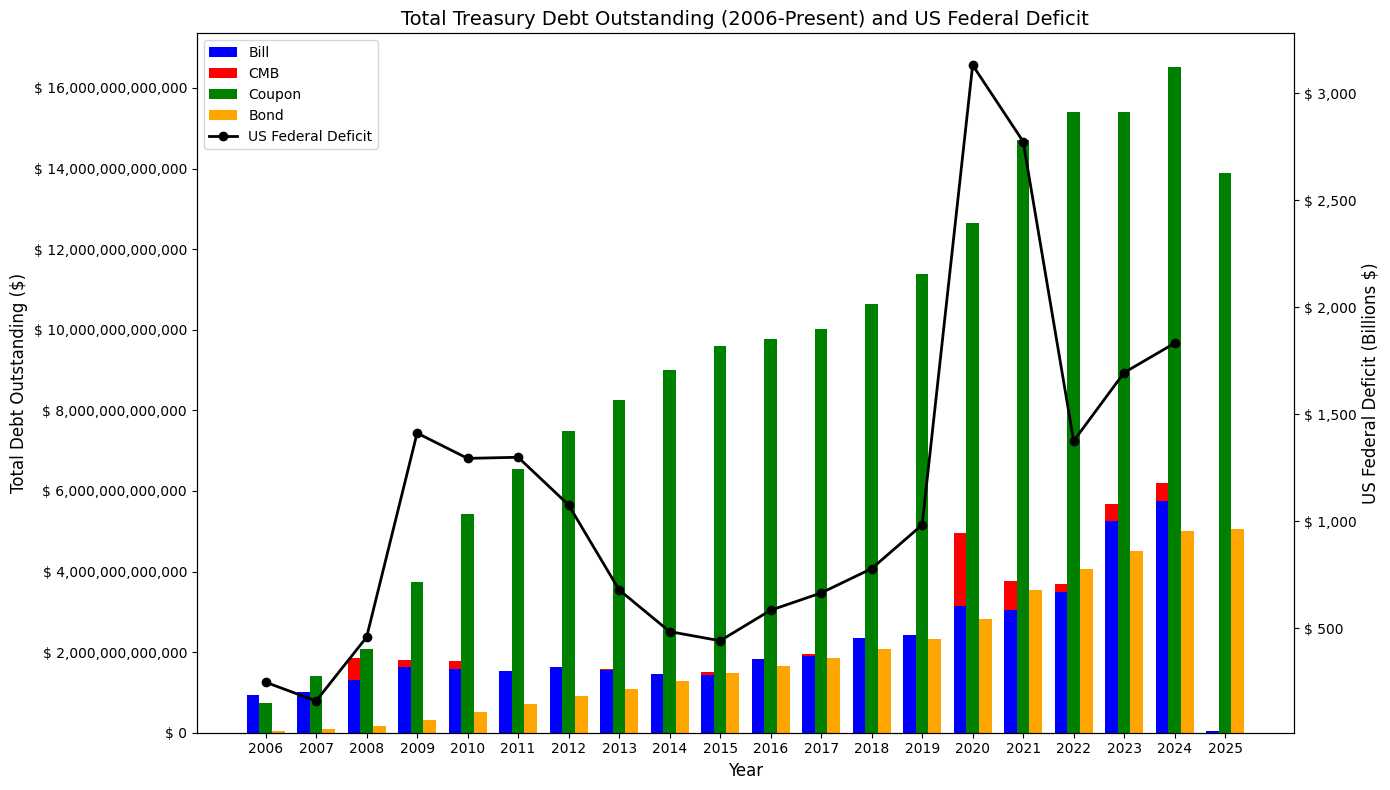

In [16]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime, timedelta
from matplotlib.ticker import StrMethodFormatter

# -----------------------------
# Part 1: Retrieve Treasury Auction Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/accounting/od/auctions_query"

params = {
    "fields": "record_date,security_type,security_term,total_accepted,maturity_date",
    "sort": "-record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

df["record_date"] = pd.to_datetime(df["record_date"])
df["maturity_date"] = pd.to_datetime(df["maturity_date"], errors='coerce')
df["total_accepted"] = pd.to_numeric(df["total_accepted"], errors="coerce")

unique_security_types = set(df["security_type"].dropna())
print("\nUnique security types found:")
print(unique_security_types)

# -----------------------------
# Part 2: Categorize Securities
# -----------------------------
def categorize_security(security_type):
    if "CMB" in security_type or "Cash Management" in security_type:
        return "CMB"
    elif "Bill" in security_type:
        return "Bill"
    elif "Note" in security_type or "Coupon" in security_type:
        return "Coupon"
    elif "Bond" in security_type:
        return "Bond"
    else:
        return "Other"

df["category"] = df["security_type"].apply(categorize_security)
df = df.dropna(subset=["total_accepted"])

# -----------------------------
# Part 3: Compute Outstanding Debt Outstanding per Year
# -----------------------------
# We want to calculate, for each year, the total amount of securities still outstanding as of December 31.
# For each year Y, we include a record if:
#   record_date <= December 31 of Y  AND  maturity_date > December 31 of Y.
start_year = 2006
current_year = datetime.today().year
years = list(range(start_year, current_year + 1))

# Create a DataFrame to hold outstanding amounts per category per year.
outstanding_dict = {}

for yr in years:
    # Define the "evaluation date" as December 31 of the given year.
    end_of_year = pd.Timestamp(year=yr, month=12, day=31)
    # Filter records that have been issued and that have not yet matured as of end_of_year.
    active = df[(df["record_date"] <= end_of_year) & (df["maturity_date"] > end_of_year)]
    # Group by category and sum the total accepted amounts.
    grp = active.groupby("category")["total_accepted"].sum()
    outstanding_dict[yr] = grp

# Convert outstanding_dict to a DataFrame.
outstanding_df = pd.DataFrame(outstanding_dict).T.fillna(0)
print("\nOutstanding Debt by Year (per category):")
print(outstanding_df.head())

# For plotting the grouped bars, we want to extract values for our chosen categories.
# We'll assume we want:
#  - "Bill" (standard Treasury Bills) and "CMB" (Cash Management Bills) combined in one grouped bar as a stacked bar.
#  - "Coupon" (e.g., Treasury Notes) and "Bond" separately.
bill_vals = outstanding_df.get("Bill", pd.Series(0, index=years))
cmb_vals = outstanding_df.get("CMB", pd.Series(0, index=years))
coupon_vals = outstanding_df.get("Coupon", pd.Series(0, index=years))
bond_vals = outstanding_df.get("Bond", pd.Series(0, index=years))

# -----------------------------
# Part 4: Retrieve US Federal Deficit Data from FRED
# -----------------------------
fred = Fred(api_key="b1b93f854d911b3cdc94df6dd9ec0365")
deficit_series = fred.get_series("FYFSD", observation_start="2006-01-01")
# Resample to annual values using year-end; FYFSD is typically reported in millions.
deficit_annual = deficit_series.resample("A").mean()

# Invert the deficit (multiply by -1) to show it as a positive number.
# Then, divide by 1000 to convert the values to billions.
deficit_annual = (-deficit_annual) / 1000

# Convert the index to year.
deficit_annual.index = deficit_annual.index.year
# Reindex to our set of years.
deficit_annual = deficit_annual.reindex(years, fill_value=np.nan)

# -----------------------------
# Part 5: Plot Grouped Bars and Federal Deficit Line
# -----------------------------
x = np.arange(len(years))
width = 0.25  # Bar width

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot a stacked bar for Bills (blue) and CMBs (red).
ax1.bar(x - width, bill_vals, width, color='blue', label='Bill')
ax1.bar(x - width, cmb_vals, width, bottom=bill_vals, color='red', label='CMB')
# Plot Coupon (green) and Bond (orange) as separate bars.
ax1.bar(x, coupon_vals, width, color='green', label='Coupon')
ax1.bar(x + width, bond_vals, width, color='orange', label='Bond')

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Total Debt Outstanding ($)", fontsize=12)
ax1.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))
ax1.set_title("Total Treasury Debt Outstanding (2006-Present) and US Federal Deficit", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

# Secondary y-axis for US Federal Deficit.
ax2 = ax1.twinx()
ax2.plot(x, deficit_annual.values, color='black', marker='o', linewidth=2, label="US Federal Deficit")
ax2.set_ylabel("US Federal Deficit (Billions $)", fontsize=12)
ax2.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))

bars, labels = ax1.get_legend_handles_labels()
line, line_label = ax2.get_legend_handles_labels()
ax1.legend(bars + line, labels + line_label, loc='upper left')

plt.tight_layout()
plt.show()

Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/debt/mspd/mspd_table_1
Response: <Response [200]>
Unique security_class_desc values in the dataset:
{'Government Account Series', 'Domestic Series', 'Floating Rate Notes', 'Notes', 'R.E.A. Series', '_', 'Other', 'Federal Financing Bank', 'United States Savings Securities', 'Hope Bonds', 'Foreign Series', 'State and Local Government Series', 'Bonds', 'Treasury Inflation-Protected Securities', 'Bills'}
Data after categorization (first 5 rows):
  record_date                      security_class_desc  total_mil_amt category
0  2006-01-31                                    Bills   9.562498e+05     Bill
1  2006-01-31                                    Notes   2.361102e+06     Note
2  2006-01-31                                    Bonds   5.166188e+05     Bond
3  2006-01-31  Treasury Inflation-Protected Securities   3.468606e+05     Tips
4  2006-01-31                   Federal Financing Bank   1.400000e+04    Other


/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_83390/1143040156.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])
/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_83390/1143040156.py:107: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  deficit_annual = deficit_series.resample("A").mean()


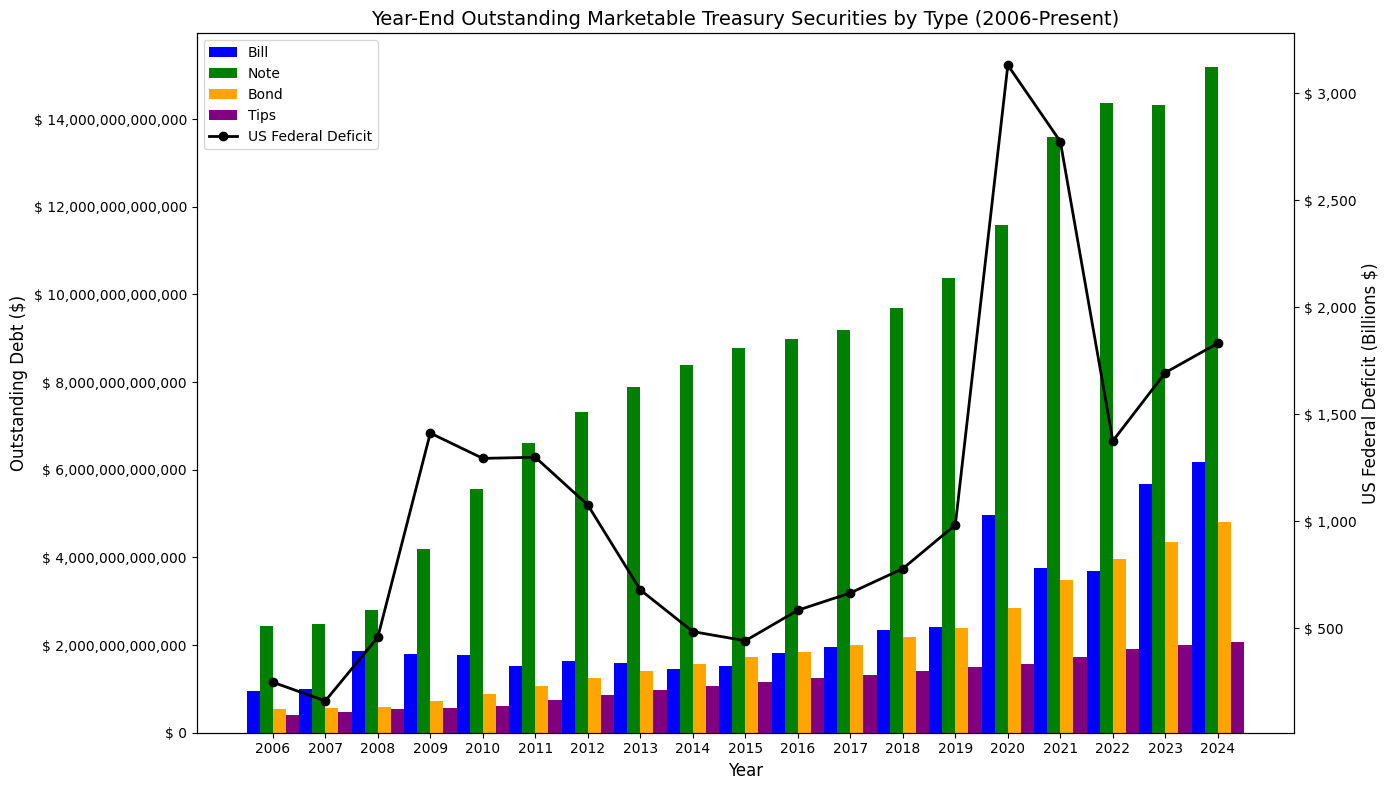

In [11]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime
from matplotlib.ticker import StrMethodFormatter

# -----------------------------
# Part 1: Retrieve the Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/debt/mspd/mspd_table_1"

# Using fields: record_date, security_class_desc, and total_mil_amt.
params = {
    "fields": "record_date,security_class_desc,total_mil_amt",
    "sort": "record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

# Convert record_date to datetime and total_mil_amt to numeric.
df["record_date"] = pd.to_datetime(df["record_date"])
df["total_mil_amt"] = pd.to_numeric(df["total_mil_amt"], errors="coerce")

# Print unique security_class_desc values.
unique_sec_types = set(df["security_class_desc"].unique())
print("Unique security_class_desc values in the dataset:")
print(unique_sec_types)

# -----------------------------
# Part 2: Categorize by Security Type
# -----------------------------
def categorize_security_desc(desc):
    desc = desc.lower()
    if "bill" in desc:
        return "Bill"
    elif "note" in desc:
        return "Note"
    elif "bond" in desc:
        return "Bond"
    elif "inflation" in desc:
        return "Tips"
    else:
        return "Other"

df["category"] = df["security_class_desc"].apply(categorize_security_desc)
print("Data after categorization (first 5 rows):")
print(df.head())

# -----------------------------
# Part 3: Get Year-End Outstanding Values
# -----------------------------
# Reset the index so that record_date is a column.
df_reset = df.reset_index(drop=True)
# Group by record_date and category, summing total_mil_amt for each day.
daily_pivot = df_reset.groupby(["record_date", "category"])["total_mil_amt"].sum().unstack(fill_value=0)
# daily_pivot now has one row per record_date with columns for each category.

# For each year, select the row with the maximum record_date.
daily_pivot["year"] = daily_pivot.index.year
annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])
# Set the index to be the year.
annual_data.index = annual_data.index.get_level_values(0)
# Convert outstanding amounts from millions to dollars.
annual_data = annual_data * 1e6

print("Annual Outstanding Debt by Type (Year-End):")
print(annual_data.head())

# Extract the values for each category.
years = sorted(annual_data.index)
bills = annual_data.get("Bill", pd.Series(0, index=years))
notes = annual_data.get("Note", pd.Series(0, index=years))
bonds = annual_data.get("Bond", pd.Series(0, index=years))
others = annual_data.get("Tips", pd.Series(0, index=years))

# -----------------------------
# Part 4: Retrieve US Federal Deficit Data from FRED (for context)
# -----------------------------
fred = Fred(api_key="b1b93f854d911b3cdc94df6dd9ec0365")
deficit_series = fred.get_series("FYFSD", observation_start="2006-01-01")
# Resample to annual using year-end values (using the mean for demonstration).
deficit_annual = deficit_series.resample("A").mean()
# Invert the deficit (multiply by -1) so that deficits appear as positive numbers,
# and divide by 1000 to convert to billions (if raw data are in millions).
deficit_annual = (-deficit_annual) / 1000
deficit_annual.index = deficit_annual.index.year
deficit_annual = deficit_annual.reindex(years, fill_value=np.nan)

# -----------------------------
# Part 5: Plot the Data
# -----------------------------
# We want 4 bars per year. We'll position them with an offset:
#   Bills at x - 1.5*width, Notes at x - 0.5*width, Bonds at x + 0.5*width, Other at x + 1.5*width.
x = np.arange(len(years))
width = 0.25  # Bar width

fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.bar(x - 1.5 * width, bills, width, color='blue', label='Bill')
ax1.bar(x - 0.5 * width, notes, width, color='green', label='Note')
ax1.bar(x + 0.5 * width, bonds, width, color='orange', label='Bond')
ax1.bar(x + 1.5 * width, others, width, color='purple', label='Tips')

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Outstanding Debt ($)", fontsize=12)
ax1.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))
ax1.set_title("Year-End Outstanding Marketable Treasury Securities by Type (2006-Present)", fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

# Secondary y-axis for the US Federal Deficit.
ax2 = ax1.twinx()
ax2.plot(x, deficit_annual.values, color='black', marker='o', linewidth=2, label="US Federal Deficit")
ax2.set_ylabel("US Federal Deficit (Billions $)", fontsize=12)
ax2.yaxis.set_major_formatter(StrMethodFormatter('$ {x:,.0f}'))

# Combine legends from both axes.
bars, labels = ax1.get_legend_handles_labels()
line, line_label = ax2.get_legend_handles_labels()
ax1.legend(bars + line, labels + line_label, loc='upper left')

plt.tight_layout()
plt.show()

/Users/aidansinclair/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/debt/mspd/mspd_table_1
Response: <Response [200]>
Raw Data (first 5 rows):
  record_date                      security_class_desc  total_mil_amt
0  2006-01-31                                    Bills   9.562498e+05
1  2006-01-31                                    Notes   2.361102e+06
2  2006-01-31                                    Bonds   5.166188e+05
3  2006-01-31  Treasury Inflation-Protected Securities   3.468606e+05
4  2006-01-31                   Federal Financing Bank   1.400000e+04
Data after categorization (first 5 rows):
  record_date                      security_class_desc  total_mil_amt category
0  2006-01-31                                    Bills   9.562498e+05     Bill
1  2006-01-31                                    Notes   2.361102e+06     Note
2  2006-01-31                                    Bonds   5.166188e+05     Bond
3  2006-01-31  Treasury Inflation-Protected Securities   3.468606e+

/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_84108/2805110211.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])


Year-Over-Year Growth (%):
category       Bill       Note       Bond       Tips
year                                                
2007       6.317481   1.909474   5.249057  14.711651
2008      85.946152  12.204995   6.551733  12.390444
2009      -3.920670  49.742085  20.716708   7.153940
2010      -1.168266  33.260097  24.318387   8.458723
2011     -14.217583  18.545475  19.199074  19.907286


/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_84108/2805110211.py:104: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  deficit_annual = deficit_series.resample("A").mean()


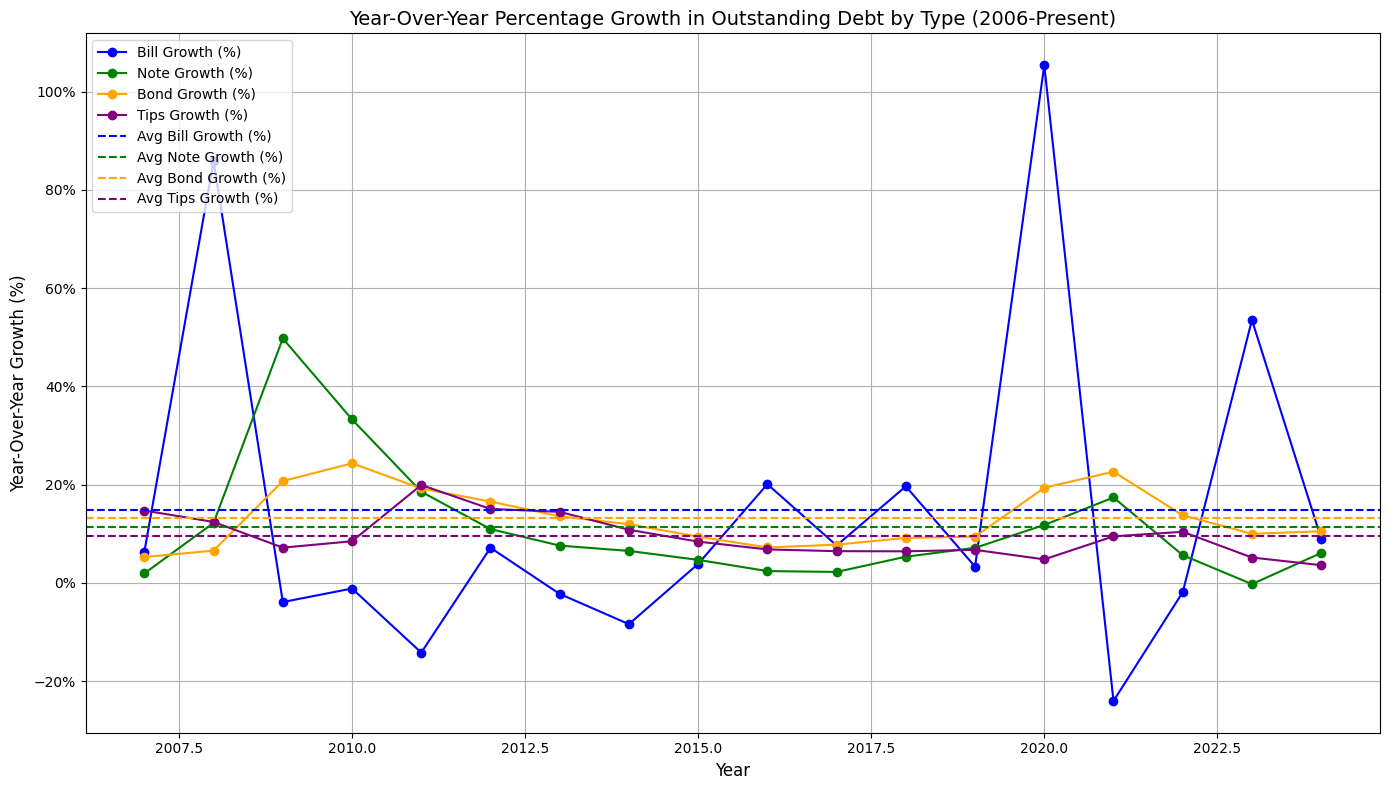

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime
from matplotlib.ticker import PercentFormatter

# -----------------------------
# Part 1: Retrieve the Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/debt/mspd/mspd_table_1"

params = {
    "fields": "record_date,security_class_desc,total_mil_amt",
    "sort": "record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

# Convert record_date to datetime and total_mil_amt to numeric.
df["record_date"] = pd.to_datetime(df["record_date"])
df["total_mil_amt"] = pd.to_numeric(df["total_mil_amt"], errors="coerce")

print("Raw Data (first 5 rows):")
print(df.head())

# -----------------------------
# Part 2: Categorize by Security Type
# -----------------------------
def categorize_security_desc(desc):
    desc = desc.lower()
    if "bill" in desc:
        return "Bill"
    elif "note" in desc:
        return "Note"
    elif "bond" in desc:
        return "Bond"
    elif "inflation" in desc:  # assuming this identifies TIPS
        return "Tips"
    else:
        return "Other"

df["category"] = df["security_class_desc"].apply(categorize_security_desc)
print("Data after categorization (first 5 rows):")
print(df.head())

# -----------------------------
# Part 3: Get Year-End Outstanding Values
# -----------------------------
# Reset the index so that record_date is a column.
df_reset = df.reset_index(drop=True)
# Group by record_date and category, summing total_mil_amt for that day.
daily_pivot = df_reset.groupby(["record_date", "category"])["total_mil_amt"].sum().unstack(fill_value=0)
# daily_pivot now has one row per record_date with columns for each category.

# For each year, select the row with the maximum record_date (year-end snapshot).
daily_pivot["year"] = daily_pivot.index.year
annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])
# Set the index to be the year.
annual_data.index = annual_data.index.get_level_values(0)
# Convert outstanding amounts from millions to dollars.
annual_data_debt = annual_data.drop(columns="year") * 1e6

print("Annual Outstanding Debt by Type (Year-End):")
print(annual_data.head())

# Extract the values for each category.
years = sorted(annual_data.index)
bills = annual_data.get("Bill", pd.Series(0, index=years))
notes = annual_data.get("Note", pd.Series(0, index=years))
bonds = annual_data.get("Bond", pd.Series(0, index=years))
tips = annual_data.get("Tips", pd.Series(0, index=years))

# -----------------------------
# Part 4: Retrieve US Federal Deficit Data from FRED (for context)
# -----------------------------
fred = Fred(api_key="b1b93f854d911b3cdc94df6dd9ec0365")
deficit_series = fred.get_series("FYFSD", observation_start="2006-01-01")
# Resample to annual using year-end values (using the mean for demonstration).
deficit_annual = deficit_series.resample("A").mean()
# Invert the deficit (multiply by -1) so that deficits appear as positive numbers,
# and divide by 1000 to convert (if raw data are in millions) to billions.
deficit_annual = (-deficit_annual) / 1000
deficit_annual.index = deficit_annual.index.year
deficit_annual = deficit_annual.reindex(years, fill_value=np.nan)

# -----------------------------
# Part 5: Compute Year-Over-Year Percentage Growth
# -----------------------------
growth_data = annual_data.pct_change() * 100  # compute percentage change
# Select only the four desired categories.
growth_data = growth_data[["Bill", "Note", "Bond", "Tips"]]
growth_data = growth_data.dropna()  # drop the first year which will be NaN

print("Year-Over-Year Growth (%):")
print(growth_data.head())

# -----------------------------
# Part 6: Plot the YOY Growth Data with Average Growth Lines
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 8))

# Plot lines for each category.
ax.plot(growth_data.index, growth_data["Bill"], marker='o', color='blue', label='Bill Growth (%)')
ax.plot(growth_data.index, growth_data["Note"], marker='o', color='green', label='Note Growth (%)')
ax.plot(growth_data.index, growth_data["Bond"], marker='o', color='orange', label='Bond Growth (%)')
ax.plot(growth_data.index, growth_data["Tips"], marker='o', color='purple', label='Tips Growth (%)')

# Compute average growth for each category.
avg_bill = growth_data["Bill"].mean()
avg_note = growth_data["Note"].mean()
avg_bond = growth_data["Bond"].mean()
avg_tips = growth_data["Tips"].mean()

# Plot horizontal dashed lines for the average growth for each category.
ax.axhline(y=avg_bill, color='blue', linestyle='--', label='Avg Bill Growth (%)')
ax.axhline(y=avg_note, color='green', linestyle='--', label='Avg Note Growth (%)')
ax.axhline(y=avg_bond, color='orange', linestyle='--', label='Avg Bond Growth (%)')
ax.axhline(y=avg_tips, color='purple', linestyle='--', label='Avg Tips Growth (%)')

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Year-Over-Year Growth (%)", fontsize=12)
ax.set_title("Year-Over-Year Percentage Growth in Outstanding Debt by Type (2006-Present)", fontsize=14)
ax.grid(True)
ax.legend(loc='upper left')

# Format y-axis as percentages.
ax.yaxis.set_major_formatter(PercentFormatter())

plt.tight_layout()
plt.show()

Request URL: https://api.fiscaldata.treasury.gov/services/api/fiscal_service/v1/debt/mspd/mspd_table_1
Response: <Response [200]>
Unique security_class_desc values in the dataset:
{'Government Account Series', 'Domestic Series', 'Floating Rate Notes', 'Notes', 'R.E.A. Series', '_', 'Other', 'Federal Financing Bank', 'United States Savings Securities', 'Hope Bonds', 'Foreign Series', 'State and Local Government Series', 'Bonds', 'Treasury Inflation-Protected Securities', 'Bills'}
Data after categorization (first 5 rows):
  record_date                      security_class_desc  total_mil_amt category
0  2006-01-31                                    Bills   9.562498e+05     Bill
1  2006-01-31                                    Notes   2.361102e+06     Note
2  2006-01-31                                    Bonds   5.166188e+05     Bond
3  2006-01-31  Treasury Inflation-Protected Securities   3.468606e+05     Tips
4  2006-01-31                   Federal Financing Bank   1.400000e+04    Other


/var/folders/43/9kgwqynj2f1b73147f7w9gj00000gn/T/ipykernel_83390/875576622.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])


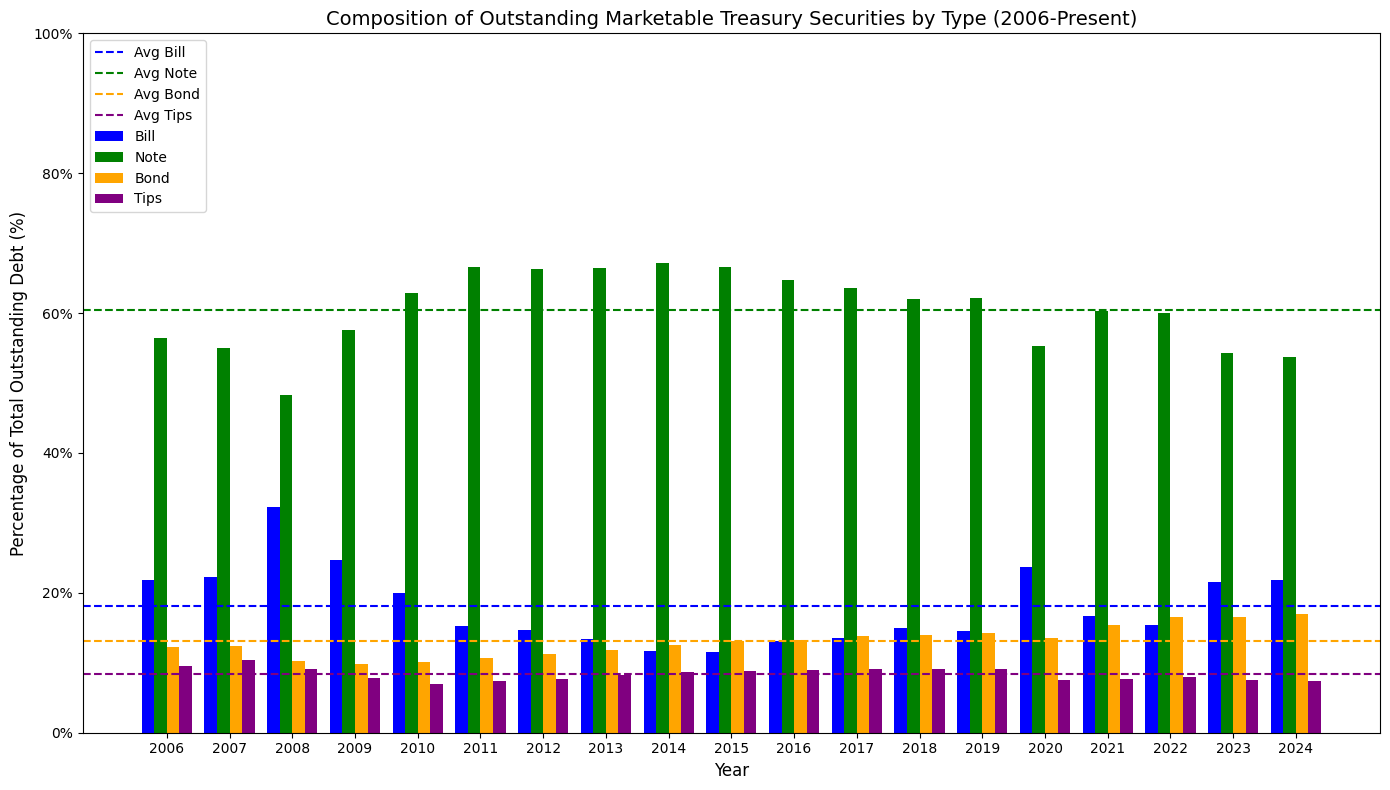

In [16]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
from datetime import datetime
from matplotlib.ticker import PercentFormatter

# -----------------------------
# Part 1: Retrieve the Data
# -----------------------------
base_url = "https://api.fiscaldata.treasury.gov/services/api/fiscal_service"
endpoint = "/v1/debt/mspd/mspd_table_1"

# Using fields: record_date, security_class_desc, and total_mil_amt.
params = {
    "fields": "record_date,security_class_desc,total_mil_amt",
    "sort": "record_date",
    "page[size]": "10000",
    "filter": "record_date:gte:2006-01-01"
}

headers = {
    "User-Agent": "Mozilla/5.0",
    "Accept": "application/json"
}

url = f"{base_url}{endpoint}"
print("Request URL:", url)
response = requests.get(url, params=params, headers=headers)
print("Response:", response)

if response.status_code != 200:
    print("Error fetching data:", response.status_code, response.text)
    exit()

json_response = response.json()
if "data" not in json_response:
    print("The JSON response does not contain a 'data' key:", json_response)
    exit()

data = json_response["data"]
df = pd.DataFrame(data)

# Convert record_date to datetime and total_mil_amt to numeric.
df["record_date"] = pd.to_datetime(df["record_date"])
df["total_mil_amt"] = pd.to_numeric(df["total_mil_amt"], errors="coerce")

# Print unique security_class_desc values.
unique_sec_types = set(df["security_class_desc"].unique())
print("Unique security_class_desc values in the dataset:")
print(unique_sec_types)

# -----------------------------
# Part 2: Categorize by Security Type
# -----------------------------
def categorize_security_desc(desc):
    desc = desc.lower()
    if "bill" in desc:
        return "Bill"
    elif "note" in desc:
        return "Note"
    elif "bond" in desc:
        return "Bond"
    elif "inflation" in desc:  # Assuming this identifies TIPS
        return "Tips"
    else:
        return "Other"

df["category"] = df["security_class_desc"].apply(categorize_security_desc)
print("Data after categorization (first 5 rows):")
print(df.head())

# -----------------------------
# Part 3: Get Year-End Outstanding Values
# -----------------------------
# Reset the index so that record_date is a column.
df_reset = df.reset_index(drop=True)
# Group by record_date and category, summing total_mil_amt for each day.
daily_pivot = df_reset.groupby(["record_date", "category"])["total_mil_amt"].sum().unstack(fill_value=0)
# daily_pivot now has one row per record_date with columns for each category.

# For each year, select the row with the maximum record_date (year-end snapshot).
daily_pivot["year"] = daily_pivot.index.year
annual_data = daily_pivot.groupby("year").apply(lambda g: g.loc[g.index.max()])
# Set the index to be the year.
annual_data.index = annual_data.index.get_level_values(0)
# Convert outstanding amounts from millions to dollars.
annual_data = annual_data * 1e6

print("Annual Outstanding Debt by Type (Year-End):")
print(annual_data.head())

# Extract the values for each category.
years = sorted(annual_data.index)
bills = annual_data.get("Bill", pd.Series(0, index=years))
notes = annual_data.get("Note", pd.Series(0, index=years))
bonds = annual_data.get("Bond", pd.Series(0, index=years))
tips = annual_data.get("Tips", pd.Series(0, index=years))

# Create a DataFrame that holds the absolute outstanding values.
abs_data = pd.DataFrame({
    "Bill": bills,
    "Note": notes,
    "Bond": bonds,
    "Tips": tips
}, index=years)

# -----------------------------
# Part 4: Compute Percentage Shares
# -----------------------------
# For each year, compute the percentage that each category contributes to the total outstanding debt.
total_outstanding = abs_data.sum(axis=1)
percent_data = abs_data.div(total_outstanding, axis=0) * 100

print("Percentage Share of Outstanding Debt by Type (Year-End):")
print(percent_data.head())

# -----------------------------
# Part 5: Compute Average Percentage for Each Type
# -----------------------------
avg_bill = percent_data["Bill"].mean()
avg_note = percent_data["Note"].mean()
avg_bond = percent_data["Bond"].mean()
avg_tips = percent_data["Tips"].mean()

# -----------------------------
# Part 6: Plot the Percentage Shares as Grouped Bars with Average Lines
# -----------------------------
x = np.arange(len(years))
width = 0.20  # Bar width

fig, ax = plt.subplots(figsize=(14, 8))

# Position the bars for each category.
ax.bar(x - 1.5*width, percent_data["Bill"], width, color='blue', label='Bill')
ax.bar(x - 0.5*width, percent_data["Note"], width, color='green', label='Note')
ax.bar(x + 0.5*width, percent_data["Bond"], width, color='orange', label='Bond')
ax.bar(x + 1.5*width, percent_data["Tips"], width, color='purple', label='Tips')

# Plot average dashed lines.
ax.axhline(y=avg_bill, color='blue', linestyle='--', label='Avg Bill')
ax.axhline(y=avg_note, color='green', linestyle='--', label='Avg Note')
ax.axhline(y=avg_bond, color='orange', linestyle='--', label='Avg Bond')
ax.axhline(y=avg_tips, color='purple', linestyle='--', label='Avg Tips')

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Percentage of Total Outstanding Debt (%)", fontsize=12)
ax.set_title("Composition of Outstanding Marketable Treasury Securities by Type (2006-Present)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.set_ylim(0, 100)
ax.yaxis.set_major_formatter(PercentFormatter())

# Combine legend entries (avoid duplicate labels).
handles, labels = ax.get_legend_handles_labels()
# To remove duplicate labels, we can create a dict.
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), loc='upper left')

plt.tight_layout()
plt.show()

In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO

# ------------------------------------------------------------------
# Define functions to fetch and process the Excel files
# ------------------------------------------------------------------

def fetch_excel_data(api_url):
    """
    Fetch an Excel file from a given URL and return a DataFrame.
    Assumes the first column contains dates.
    """
    response = requests.get(api_url)
    if response.status_code == 200:
        # Read Excel from the downloaded bytes; 
        # adjust header/index_col as needed based on file structure.
        return pd.read_excel(BytesIO(response.content), index_col=0, parse_dates=True)
    else:
        print(f"Failed to fetch data: {response.status_code} for {api_url}")
        return None

def process_file(api_url):
    """
    Process one Excel file:
      - Download the file.
      - Sum across all numeric columns (assumed to be different subcategories)
        to get a daily total.
      - Resample to monthly frequency taking the last available day.
    Returns a DataFrame with a 'Total' column and a datetime index.
    """
    df = fetch_excel_data(api_url)
    if df is None:
        return None
    # Sum all numeric columns to get a daily total.
    df['Total'] = df.select_dtypes(include='number').sum(axis=1)
    # Resample to monthly frequency taking the last available observation.
    df_monthly = df.resample('M').last()[['Total']]
    return df_monthly

def aggregate_period(urls):
    """
    Given a list of API URLs for a reporting period,
    process each file and aggregate (sum) their totals by date.
    Returns a DataFrame with a datetime index and a combined 'Total' column.
    """
    monthly_totals = []  # list of DataFrames for each file
    for url in urls:
        df = process_file(url)
        if df is not None:
            monthly_totals.append(df)
    if not monthly_totals:
        return None
    # Combine (concatenate) the DataFrames along columns so that they align by date
    combined = pd.concat(monthly_totals, axis=1)
    # Sum across the columns to get one total per date.
    combined['Total'] = combined.sum(axis=1)
    return combined[['Total']]

# ------------------------------------------------------------------
# Define the API URLs for each period.
# (The URLs below are taken from your list.)
# ------------------------------------------------------------------

# Period 1: Jan 2015 to Dec 2021
urls_2015_2021 = [
    "https://markets.newyorkfed.org/api/pd/get/SBN2015/timeseries/PDSIRRA-UTSET_PDSIRRA-UTSETTAL30_PDSIRRA-UTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2015/timeseries/PDSIOSB-UTSET_PDSIOSB-UTSETTA30_PDSIOSB-UTSETTAG30.xlsx"
]

# Period 2: Jan 2022 to Jun 2024
urls_2022_2024 = [
    "https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSIRRA-UBSUTSET_PDSIRRA-UBSUTSETTAL30_PDSIRRA-UBSUTSETTAG30_PDSIRRA-UBGUTSET_PDSIRRA-UBGUTSETTAL30_PDSIRRA-UBGUTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSIRRA-CBSUTSET_PDSIRRA-CBSUTSETTAL30_PDSIRRA-CBSUTSETTAG30_PDSIRRA-CBGUTSET_PDSIRRA-CBGUTSETTAL30_PDSIRRA-CBGUTSETTAG30_PDSIRRA-CBSPUTSET_PDSIRRA-CBSPUTSETTAL30_PDSIRRA-CBSPUTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSIRRA-GCFUTSET_PDSIRRA-GCFUTSETTAL30_PDSIRRA-GCFUTSETTAG30_PDSIRRA-TRIUTSET_PDSIRRA-TRIUTSETTAL30_PDSIRRA-TRIUTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2022/timeseries/PDSIOSB-UTSET_PDSIOSB-UTSETTA30_PDSIOSB-UTSETTAG30.xlsx"
]

# Period 3: Jun 2024 to Present
urls_2024_present = [
    "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSORA-UBSE_PDSORA-UBSETAL30_PDSORA-UBSETAG30_PDSORA-UBGE_PDSORA-UBGETAL30_PDSORA-UBGETAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSIRRA-CBSUTSET_PDSIRRA-CBSUTSETTAL30_PDSIRRA-CBSUTSETTAG30_PDSIRRA-CBGUTSET_PDSIRRA-CBGUTSETTAL30_PDSIRRA-CBGUTSETTAG30_PDSIRRA-CBSPUTSET_PDSIRRA-CBSPUTSETTAL30_PDSIRRA-CBSPUTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSIRRA-GCFUTSET_PDSIRRA-GCFUTSETTAL30_PDSIRRA-GCFUTSETTAG30_PDSIRRA-TRIGUTSET_PDSIRRA-TRIGUTSETTAL30_PDSIRRA-TRIGUTSETTAG30_PDSIRRA-TRISPUTSET_PDSIRRA-TRISPUTSETTAL30_PDSIRRA-TRISPUTSETTAG30.xlsx",
    "https://markets.newyorkfed.org/api/pd/get/SBN2024/timeseries/PDSIOSB-UTSET_PDSIOSB-UTSETTA30_PDSIOSB-UTSETTAG30.xlsx"
]

# ------------------------------------------------------------------
# Process each period and aggregate the data.
# ------------------------------------------------------------------

df_2015_2021 = aggregate_period(urls_2015_2021)
df_2022_2024 = aggregate_period(urls_2022_2024)
df_2024_present = aggregate_period(urls_2024_present)

# Combine all periods into a single DataFrame and sort by date.
df_total = pd.concat([df_2015_2021, df_2022_2024, df_2024_present]).sort_index()

# ------------------------------------------------------------------
# Plot the aggregated reverse repo volume (last day of month)
# ------------------------------------------------------------------

plt.figure(figsize=(12, 6))
plt.plot(df_total.index, df_total['Total'], marker="o", label="Total Reverse Repo Volume")
plt.title("Aggregated Reverse Repo Volume (Last Day of Month)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volume", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.